## Counting simplex-containing DAG2.

In this notebook, we will try to count all simplex-containing DAG2, that is DAG2 robust motifs on n nodes that contain an n-1 simplex.

### Imports 

Core imports

In [1]:
import multiprocessing as mp
from robust_motifs.multiprocessing import prepare_shared_memory
from robust_motifs.counting import get_dag2_signature
from robust_motifs.data import import_connectivity_matrix, save_er_graph, load_sparse_matrix

File tools

In [2]:
from pathlib import Path
import pickle
import h5py

Drawing tools

In [3]:
from robust_motifs.plot import plot_matrices
from robust_motifs.utilities import get_pos

Other tools

In [4]:
import scipy.sparse as sp
import numpy as np
from itertools import product
from time import time

# Layer 4

### Layer 4 data

Import single layer adjacency data.

In [7]:
matrix_path = Path('data/tesi/test_instance/cons_locs_pathways_mc0_Column.h5')
A = import_connectivity_matrix(matrix_path)
l4_zones = [col for col in A.columns.levels[0] if col.startswith('L4')]
l4_matrix = import_connectivity_matrix(matrix_path, zones = l4_zones, dataframe = False, type = 'csr')

100%|██████████| 12/12 [00:00<00:00, 38.74it/s]


In [8]:
l4_matrix

<4660x4660 sparse matrix of type '<class 'numpy.bool_'>'
	with 346232 stored elements in Compressed Sparse Row format>

Import simplex data.

In [7]:
count_path = matrix_path.with_name('L4-count.h5')
l4_simplex_file = h5py.File(count_path, 'r')

Import corresponding ER graph data.

In [8]:
er_matrix_path = Path('data/tesi/test_instance/ER_L4_adj.pkl')
er_count_path = er_matrix_path.with_name('ER_L4-count.h5')
er_matrix = sp.csr_matrix(pickle.load(open(er_matrix_path, 'rb')), dtype = np.int8)
er_simplex_file = h5py.File(er_count_path, 'r')


### Preparing multiprocessing tools

To speed up execution and avoid memory leaks, the full connectivity matrix is shared in sparse format between simplices using the multiprocessing module.

In [9]:
pool = mp.Pool()
l4_arrays, l4_links = prepare_shared_memory(l4_matrix, 'l4')
er_arrays, er_links = prepare_shared_memory(er_matrix, 'er')

Process ForkPoolWorker-5:
Process ForkPoolWorker-7:
Process ForkPoolWorker-8:
Process ForkPoolWorker-6:
Process ForkPoolWorker-4:
Process ForkPoolWorker-10:
Process ForkPoolWorker-9:
Process ForkPoolWorker-12:
Process ForkPoolWorker-11:
Process ForkPoolWorker-1:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


In [10]:
l4_arrays

{'data': {'name': 'l4data',
  'size': 346232,
  'type': dtype('bool'),
  'factor': 1},
 'indices': {'name': 'l4indices',
  'size': 1384928,
  'type': dtype('int32'),
  'factor': 4},
 'indptr': {'name': 'l4indptr',
  'size': 18644,
  'type': dtype('int32'),
  'factor': 4}}

In [11]:
er_arrays

{'data': {'name': 'erdata',
  'size': 347275,
  'type': dtype('int8'),
  'factor': 1},
 'indices': {'name': 'erindices',
  'size': 1389100,
  'type': dtype('int32'),
  'factor': 4},
 'indptr': {'name': 'erindptr',
  'size': 18644,
  'type': dtype('int32'),
  'factor': 4}}

### Count - dimension 4 simplices

Dimension 4 has a low number of simplices, but enough to see iterations speed.

In [13]:
simplex_iterator = iter(l4_simplex_file['Cells_4'][:10000])
mp_iterator = product(simplex_iterator, [l4_arrays])
results = pool.imap(get_dag2_signature, mp_iterator)

In [14]:
a = time()
dags2 = []
for elem in results:
    dags2.append(elem)
print(time()-a)

4.3318774700164795


In [19]:
def get_combinations(boolean_array):
    elems = [[False,True] if elem else [False] for elem in boolean_array]
    return product(*elems)

At this point, we have all the DAGs-containing sets of nodes with the 'maximal' ones. We just need to convert the list to the full list with all interesting sub-graphs

In [20]:
true_dags = []
removed_list = []
for simplex in dags2:
    for dag2 in simplex:
        for signature in get_combinations(dag2[1]):
            if (
                np.all(signature) and
                np.all([not (np.array(dag2[0]) == elem).all() for elem in removed_list])
            ):
                removed_list.append( np.concatenate(
                        (dag2[0][:-2], [dag2[0][-1]] + [dag2[0][-2]])
                        )
                    )
            else:
                true_dags.append(
                    (dag2[0],
                    signature)
                )

In [21]:
removed_list

[array([ 488,  580,  436, 1056, 4470,  907], dtype=int32),
 array([ 488,  580, 1056,  436, 4470,  907], dtype=int32),
 array([ 536, 2577,  877, 2868, 2024,  712], dtype=int32),
 array([ 964, 2156, 3042, 4088, 1227,  463], dtype=int32)]

In [22]:
len(dags2)

10000

In [23]:
len(true_dags)

71148

Some simplices were removed because they would have been counted twice. They are the "bisimplices".

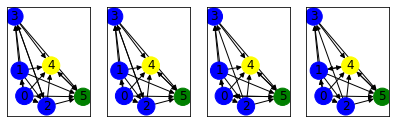

In [24]:
matrix_list = [l4_matrix[removed_simplex].T[removed_simplex].T for removed_simplex in removed_list]
plot_matrices(matrix_list, {
    'pos': list(get_pos(6)),
    'node_color': ['blue','blue','blue','blue','yellow','green']})

### Closing temporary memory

In [2]:
for element in l4_links:
    element.unlink
for element in er_links:
    element.unlink

NameError: name 'l4_links' is not defined

# All layers

Import adjacency data.

In [5]:
matrix_path = Path('data/tesi/test_instance/cons_locs_pathways_mc0_Column.h5')
matrix = import_connectivity_matrix(matrix_path, dataframe = False, type = 'csr')

100%|██████████| 55/55 [00:12<00:00,  4.46it/s]


Import simplex data.

In [6]:
count_path = matrix_path.with_name('column-count.h5')
simplex_file = h5py.File(count_path, 'r')

Create ER data

In [7]:
matrix

<31346x31346 sparse matrix of type '<class 'numpy.int8'>'
	with 7648079 stored elements in Compressed Sparse Row format>

In [44]:
er_flag_path = Path('data/tesi/test_instance/ER_column.flag')

In [9]:
save_er_graph(er_flag_path, 31346, 7648079/31346/31346)

100%|██████████| 31346/31346 [00:00<00:00, 2262591.26it/s]
7650242it [00:11, 688008.94it/s]


Use flagser

In [10]:
!flagser-count data/tesi/test_instance/ER_column.flag --out data/tesi/test_instance/ER_column-count.h5

# [euler_characteristic cell_count_dim_0 cell_count_dim_1 ...]
6702950 31346 7650242 14536893 215073 26


Import data

In [45]:
er_matrix_path = er_flag_path.with_suffix('.pkl')
er_count_path = er_flag_path.with_name('ER_column-count.h5')
er_matrix = load_sparse_matrix(er_matrix_path)
er_simplex_file = h5py.File(er_count_path, 'r')


### Preparing multiprocessing tools

In [46]:
pool = mp.Pool()
arrays, links = prepare_shared_memory(matrix, 'whole_')
er_arrays, er_links = prepare_shared_memory(er_matrix, 'er_')

In [47]:
arrays

{'data': {'name': 'whole_data',
  'size': 7648079,
  'type': dtype('int8'),
  'factor': 1},
 'indices': {'name': 'whole_indices',
  'size': 30592316,
  'type': dtype('int32'),
  'factor': 4},
 'indptr': {'name': 'whole_indptr',
  'size': 125388,
  'type': dtype('int32'),
  'factor': 4}}

In [48]:
er_arrays

{'data': {'name': 'er_data',
  'size': 61201936,
  'type': dtype('int64'),
  'factor': 8},
 'indices': {'name': 'er_indices',
  'size': 30600968,
  'type': dtype('int32'),
  'factor': 4},
 'indptr': {'name': 'er_indptr',
  'size': 125388,
  'type': dtype('int32'),
  'factor': 4}}

### Count - dimension 5 simplices

In [49]:
len(simplex_file['Cells_5'])

133115

Dimension 5 has a low number of simplices, but enough to see iterations speed.

In [58]:
simplex_iterator = iter(simplex_file['Cells_5'][:20000])
mp_iterator = product(simplex_iterator, [arrays])
results = pool.imap(get_dag2_signature, mp_iterator)

In [59]:
a = time()
dags2 = []
for elem in results:
    dags2.append(elem)
print(time() - a)

71.54247641563416


In [15]:
def get_combinations(boolean_array):
    elems = [[False,True] if elem else [False] for elem in boolean_array]
    return product(*elems)

In [16]:
true_dags = []
removed_list = []
for simplex in dags2:
    for dag2 in simplex:
        for signature in get_combinations(dag2[1]):
            if (
                np.all(signature) and
                np.all([not (np.array(dag2[0]) == elem).all() for elem in removed_list])
            ):
                removed_list.append( np.concatenate(
                        (dag2[0][:-2], [dag2[0][-1]] + [dag2[0][-2]])
                        )
                    )
            else:
                true_dags.append(
                    (dag2[0],
                    signature)
                )

In [17]:
removed_list

[array([ 488,  580,  436, 1056, 4470,  907], dtype=int32),
 array([ 488,  580, 1056,  436, 4470,  907], dtype=int32),
 array([ 536, 2577,  877, 2868, 2024,  712], dtype=int32),
 array([ 964, 2156, 3042, 4088, 1227,  463], dtype=int32),
 array([1228,  492, 1270,  994, 2171, 1368], dtype=int32),
 array([1292, 1545, 1316, 3141, 1923,  784], dtype=int32),
 array([1588, 2264, 2432, 1897,  505,  420], dtype=int32),
 array([1608, 2162, 2679, 3913, 3017,  687], dtype=int32),
 array([1757,  458, 2535,  420, 1709, 1041], dtype=int32),
 array([1757,  458, 4592,  420, 1709, 1041], dtype=int32),
 array([1757, 2215, 2535,  420, 1709, 1041], dtype=int32),
 array([1764, 2966, 2439, 2779, 1676, 1022], dtype=int32),
 array([1793,  541, 2107,  960, 2776, 1874], dtype=int32),
 array([1793, 2107,  541,  960, 2776, 1874], dtype=int32),
 array([1886, 1565,  458,  928, 1665,  494], dtype=int32),
 array([1886, 1565,  928,  458, 1665,  494], dtype=int32),
 array([2107, 1793,  541,  960, 2776, 1874], dtype=int32

In [18]:
len(dags2)

37136

In [19]:
len(true_dags)

262934

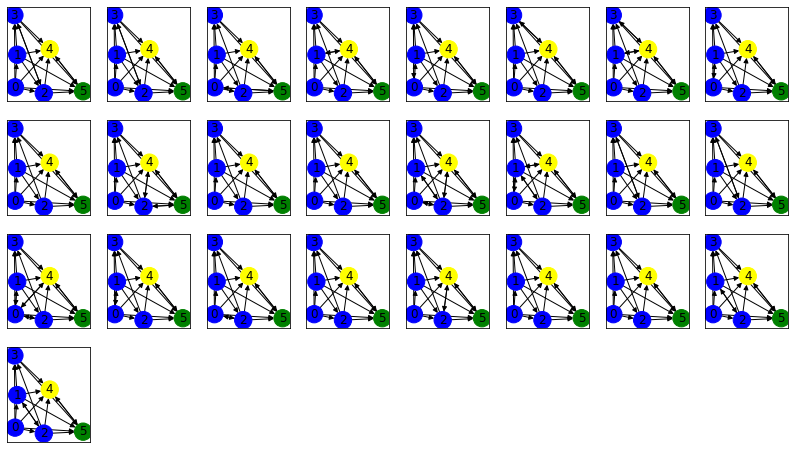

In [20]:
matrix_list = [l4_matrix[removed_simplex].T[removed_simplex].T for removed_simplex in removed_list]
plot_matrices(matrix_list, {
    'pos': list(get_pos(6)),
    'node_color': ['blue','blue','blue','blue','yellow','green']})

### Closing temporary memory

In [1]:
for element in links:
    element.unlink
for element in er_links:
    element.unlink

NameError: name 'links' is not defined